Primeiramente gostaria de agradecer a sua iniciativa de querer fazer parte do time da Fidelity Pesquisas Cadastrais e parabéns por ter chegado nessa etapa! Esperamos vê-lo(a) na próxima etapa!

Nesse momento iremos realizar um teste técnico para entendermos melhor as suas hard skills e se estão alinhadas com as necessidades que temos internamente, então bora por a mão na massa!!

---

**ORIENTAÇÕES**

1. Você terá um prazo de 7 dias corridos para realizar a entrega desse desafio técnico, contando a partir da data de envio. Data Limite: 22/07/2025 18h00;
2. Após a conclusão, pedimos que envie um e-mail para daniel_duperron@hotmail.com e coloque em cópia o e-mail pedro.chaves@fidelitypesquisas.com.br com o link do repositório do GitHub onde o desafio está alocado. Não se esqueça de deixá-lo público;
3. O repositório deverá ser nomeado como “desafio-fidelity”;
---

**DESAFIO TÉCNICO**

O script apresentado tem como objetivo realizar a consulta de pesquisas nas plataformas de Tribunal Jurídico do Brasil de forma automatizada.

Para esse desafio, precisamos que você organize os arquivos existentes seguindo as boas práticas e busque entender e melhorar a lógica das funções, enxugando as consultas e a forma com que foram definidas.

Deve-se seguir o modelo das tabelas abaixo para desenvolver a arquitetura do banco de dados usando o PostegreSQL. Se julgar necessário você poderá reformular as tabelas e desenvolver uma nova estrutura que deverá ser apresentado na entrevista técnica.

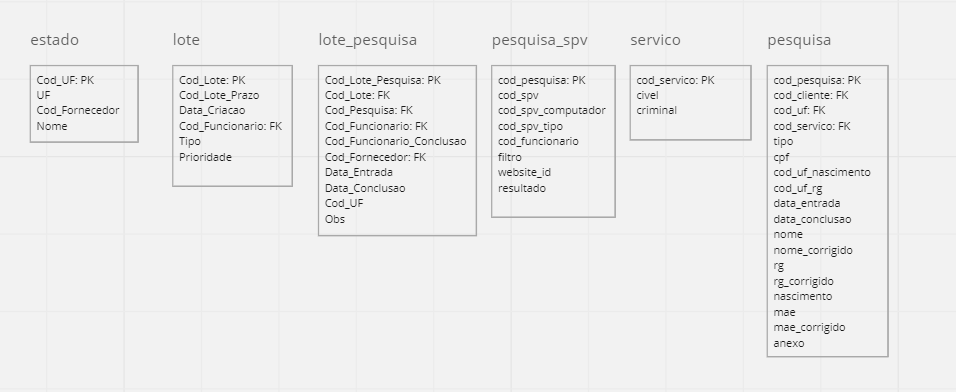



In [ ]:
import datetime
import mariadb
import sys
import os
import time
from selenium.webdriver.support.select import Select
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.edge.options import Options
from tqdm import tqdm

NADA_CONSTA = 'Não existem informações disponíveis para os parâmetros informados.'
CONSTA01 = 'Processos encontrados'
CONSTA02 = 'Audiências'
FILTRO = 0
EXECUTAVEL = 'C:/Users/teste/OneDrive/Documentos/'

class SPVAutomatico():

    def __init__(self, filtro=''):
        self.filtro = filtro

    # Esse método inicia o sistema e consulta as pesquisas que estão em aberto no banco de dados.
    # Esse método deve ser atualizado realizando a consulta utilizando o conceito de paginação.
    @staticmethod
    def conectaBD(filtro):
            con = mariadb.connect(host='10.0.270.18', user='usr_teste', password='teste', database='db_teste')
            cursor = con.cursor()
            cond = ''
            if (filtro == 1 or filtro == 3):
                cond = ' AND rg <> "" '

            sql = 'SELECT DISTINCT p.Cod_Cliente, p.Cod_Pesquisa,  e.UF, p.Data_Entrada, coalesce(p.nome_corrigido, p.nome) AS Nome, p.CPF, coalesce(p.rg_corrigido, p.rg) AS RG, p.Nascimento, coalesce(p.mae_corrigido, p.mae) AS Mae, p.anexo AS Anexo, ps.Resultado, ps.cod_spv_tipo FROM pesquisa p INNER JOIN servico s ON p.Cod_Servico = s.Cod_Servico LEFT JOIN lote_pesquisa lp ON p.Cod_Pesquisa = lp.Cod_Pesquisa LEFT JOIN lote l ON l.cod_lote = lp.cod_lote LEFT JOIN estado e ON e.Cod_UF = p.Cod_UF LEFT JOIN pesquisa_spv ps ON ps.Cod_Pesquisa = p.Cod_Pesquisa AND ps.Cod_SPV = 1 AND ps.filtro = '+str(filtro)+' WHERE p.Data_Conclusao IS NULL  AND ps.resultado IS NULL   AND p.tipo = 0   AND p.cpf <> "" '+cond+' AND (e.UF = "SP" OR p.Cod_UF_Nascimento = 26  OR p.Cod_UF_RG = 26) GROUP BY p.cod_pesquisa ORDER BY nome ASC, resultado DESC LIMIT 210'

            cursor.execute(sql)

            qry = cursor.fetchall()

            cursor.close()
            return qry

    # Esse método possui a função de consultar a pesquisa no banco de dados e executá-la utilizando a biblioteca Selenoid.
    # A parte da execução é aplicada utilizando o método executaPesquisa().
    def pesquisa(self):
        w = 0
        tempo_inicio = datetime.datetime.now()

        filtro = self.filtro
        i = self.filtro
        qry = self.conectaBD(filtro)

        totPesquisas = len(qry)
        if (totPesquisas > 0):

            for dados in tqdm(qry):
                codCliente = dados[0]
                codPesquisa = dados[1]
                uf = dados[2]
                dataEntrada = dados[3]
                nome = dados[4]
                cpf = dados[5]
                rg = dados[6]
                dataNascimento = dados[7]
                nomeMae = dados[8]
                anexo = dados[9]
                resultado = dados[10]
                spvTipo = dados[11]

                self.executaPesquisa(self, filtro, nome, cpf, rg, codPesquisa, spvTipo)
                tempo_fim = datetime.datetime.now()
                tempo_gasto = round((tempo_fim - tempo_inicio).total_seconds(), 2)
                if (tempo_gasto >= 600):
                    break


            tempo_gasto = 0
            i = i + 1
            if (i <= 3):
                print('RECOMENÇANDO COM O FILTRO '+ str(i))
                p = SPVAutomatico(i)
                p.pesquisa()
            else:
                print('RECOMEÇANDO')
                self.restarta_programa(self)
        else:

            # TENTA COM O PRÓXIMO FILTRO

            w = w + 1
            print('AGUARDANDO PARA RECOMEÇAR')
            time.sleep(60)
            if (w >= 20):
                time.sleep(3600)
                self.restarta_programa(self)
            else:
                self.restarta_programa(self)

    # Esse método tem como função realizar todos os passos da pesquisa, após a sua consulta no banco de dados.
    # Com isso é realizada a busca no navegador, a validação do resultado e a inserção do resultado no banco de dados.
    @staticmethod
    def executaPesquisa(self,filtro, nome, cpf, rg, codPesquisa, spvTipo):

        if (filtro == 0 and cpf != None):
            site = self.carregaSite(self, filtro, cpf)
            result = self.checaResultado(site, codPesquisa)
            sql = 'insert into pesquisa_spv (Cod_Pesquisa, Cod_SPV, Cod_spv_computador, Cod_Spv_Tipo, Resultado, Cod_Funcionario, filtro, website_id) values ('+str(codPesquisa)+', 1, 36, NULL, '+str(result)+', -1, '+ str(filtro)+', 1)'
            con = mariadb.connect(host='10.0.270.18', user='usr_teste', password='teste', database='db_teste')
            cursor = con.cursor()
            cursor.execute(sql)
            cursor.close()

        elif (filtro == 3 or filtro == 1 and rg != None and rg != ''):
            site = self.carregaSite(self, filtro, rg)
            result = self.checaResultado(site, codPesquisa)
            sql = 'insert into pesquisa_spv (Cod_Pesquisa, Cod_SPV, Cod_spv_computador, Cod_Spv_Tipo, Resultado, Cod_Funcionario, filtro, website_id) values ('+str(codPesquisa)+', 1, 36, NULL, '+str(result)+', -1, '+ str(filtro)+', 1)'
            con = mariadb.connect(host='10.0.270.18', user='usr_teste', password='teste', database='db_teste')
            cursor = con.cursor()
            cursor.execute(sql)
            cursor.close()

        elif (filtro == 2 and nome != None and nome != ''):
            site = self.carregaSite(self, filtro, nome)
            result = self.checaResultado(site, codPesquisa)
            sql = 'insert into pesquisa_spv (Cod_Pesquisa, Cod_SPV, Cod_spv_computador, Cod_Spv_Tipo, Resultado, Cod_Funcionario, filtro, website_id) values ('+str(codPesquisa)+', 1, 36, NULL, '+str(result)+', -1, '+ str(filtro)+', 1)'
            con = mariadb.connect(host='10.0.270.18', user='usr_teste', password='teste', database='db_teste')
            cursor = con.cursor()
            cursor.execute(sql)
            cursor.close()

    # Esse método tem como função enquadrar a pesquisa de acordo com o resultado obtido na pesquisa como Nada Consta, Consta
    # Criminal e Consta Cível.
    @staticmethod
    def checaResultado(site, codPesquisa):
        final_result = 7
        if (NADA_CONSTA in site):
            final_result = 1
        elif ((CONSTA01 in site) or (CONSTA02 in site)) and \ ('Criminal' in site) or ('criminal' in site):
            final_result = 2
        elif ((CONSTA01 in site) or (CONSTA02 in site)):
            final_result = 5

        return final_result

    # Esse método tem como função buscar a pesquisa na plataforma online utilizando o Selenoid.
    # Nesse caso a função está aplicando a apenas uma plataforma, mas precisamos que seja modularizado.
    @staticmethod
    def carregaSite(self, filtro, documento):
        service = Service(executable_path=EXECUTAVEL+"msedgedriver.exe")
        options = Options()
        options.add_argument("-headless")
        options.add_experimental_option('excludeSwitches', ['enable-logging'])
        browser = webdriver.Edge(service=service, options=options)
        browser.get("https://esaj.tjsp.jus.br/cpopg/open.do")

        if (filtro == 0 or filtro == 1 or filtro == 3):
            try:
                select_el = browser.find_element('xpath','//*[@id="cbPesquisa"]')
                select_ob = Select(select_el)
                select_ob.select_by_value('DOCPARTE')
                browser.find_element('xpath','//*[@id="campo_DOCPARTE"]').send_keys(documento)
                browser.find_element('xpath','//*[@id="botaoConsultarProcessos"]').click()
            except:
                time.sleep(120)
                self.restarta_programa(self)
        elif (filtro == 2):
            try:
                select_el = browser.find_element('xpath','//*[@id="cbPesquisa"]')
                select_ob = Select(select_el)
                select_ob.select_by_value('NMPARTE')
                browser.find_element('xpath','//*[@id="pesquisarPorNomeCompleto"]').click()
                browser.find_element('xpath','//*[@id="campo_NMPARTE"]').send_keys(documento)
                browser.find_element('xpath','//*[@id="botaoConsultarProcessos"]').click()
            except:
                time.sleep(120)
                self.restarta_programa(self)
        return browser.page_source

    # Esse método tem como função reiniciar o sistema.
    @staticmethod
    def restarta_programa(self):
        try:
            python = sys.executable
            os.execl(python, python, * sys.argv)
        except:
            print('PROGRAMA ENCERRADO')
            quit()


p = SPVAutomatico(0)
p.pesquisa()